# Анализ лояльности пользователей Яндекс Афиши

- Автор: Литвинов Олег Игоревич
- Дата: 

### Цели и задачи проекта



### Этапы выполнения проекта

#### Подготовка к работе
1. Создание локального репозитория (venv, .gitignore)
2. Создание репозитория на Github
3. Создание .env с конфигурацией данных для подключения к бд
#### Загрузка данных и знакомство с ними
1. Подключение к бд через .env
1. SQL запрос для выгрузки в датафрейм
2. Общая информация о данных
#### Предобработка данных
1. Обработка данных по выручке
1. Проверка пропусков
2. Преобразование к необходимому типу
4. Проверка данных в числовых столбцах
5. Промежуточный вывод
#### Создание профиля пользователя
1. Агрегированные признаки, описывающие поведение и профиль каждого пользователя
2. Анализ данных в разрезе каждого пользователя
#### Исследовательский анализ данных
1. Исследование признаков первого заказа
2. Исследование вернувшихся пользователей
3. Проверка продуктовых гипотез
4. Исследование поведения пользователей через показатели выручки и состава заказа
5. Исследование временных характеристик первого заказа и их влияния на повторные покупки
6. Корреляционный анализ количества покупок и признаков пользователя
#### Общие выводы и рекомендации
#### Финализация проекта и публикация в Git
1. Создание requirements.txt
2. Финальный коммит и пуш в Github 

## Подготовка к работе

Все шаги выполнены локально. Вирт окружение создано, локальный репозиторий создан.

## Загрузка данных и знакомство с ними

In [1]:
# загружаем необходимые библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine


In [2]:
# загружаем переменные из .env

load_dotenv()

db_config = {
    'user': os.getenv('DB_USER'),
    'pwd': os.getenv('DB_PASSWORD'), 
    'host': os.getenv('DB_HOST'),
    'port': os.getenv('DB_PORT'),
    'db': os.getenv('DB_NAME')
}

In [3]:
# создаём строку для соединения с базой данных из переменных

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [4]:
# подключаемся

engine = create_engine(connection_string)

In [5]:
# пишем запрос в переменную

query = '''
WITH set_config_precode AS (
  SELECT set_config('synchronize_seqscans', 'off', true)
)
SELECT  p.user_id,
        p.device_type_canonical,
        p.order_id,
        p.created_dt_msk AS order_dt,
        p.created_ts_msk AS order_ts,
        p.currency_code,
        p.revenue,
        p.tickets_count,
        EXTRACT(DAY FROM (created_dt_msk - LAG(created_dt_msk) OVER(
            PARTITION BY user_id 
            ORDER BY created_dt_msk
          ))) AS days_since_prev,
        p.event_id,
        e.event_name_code AS event_name,
        e.event_type_main,
        p.service_name,
        r.region_name,
        c.city_name
FROM afisha.purchases AS p
JOIN afisha.events e USING(event_id)
LEFT JOIN afisha.city c USING(city_id)
LEFT JOIN afisha.regions r USING(region_id)
WHERE p.device_type_canonical IN ('mobile', 'desktop') and e.event_type_main != 'фильм'
ORDER BY p.user_id
;
'''

In [6]:
# получаем результат, записываем в датафрейм

df = pd.read_sql_query(query, con=engine) 
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


In [7]:
# общая информация о датасете

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

Датасет содержит 15 столбцов и 290611 строк, в которых представлена информация о пользователях и их заказах на сервисе `Я.Афиша`.

Описание данных:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ ( mobile — мобильные устройства, desktop — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные created_dt_msk );
- `order_ts` — дата и время создания заказа (используйте данные created_ts_msk );
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `event_name` - название мероприятия в закодированном виде;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

Наблюдения:
- имена столбцов имеют единый вид - snake case и не содержат пробелов
- данные в столбцах соответствуют описанию
- имеем хороший набор данных без пропусков (пропуски только в столбце `days_since_prev`, но мы сами их туда поставили и знаем о чём они говорят)
- по возможности можно уменьшить размер занимаемой памяти, поменяв данные на подходящий тип
- большинство данных имеет тип `object` - 8 столбцов, 2 столбца с данными `datetime64`, целочисленный тип `int64` - 3 столбца, `float64` - 2

In [8]:
# сделаем копию датасета

df_original = df.copy()

# проверим

len(df_original)

290611

## Предобработка данных

### Обработка данных по выручке

In [9]:
# посмотрим в какой валюте представленны данные о выручке

df['currency_code'].value_counts()

currency_code
rub    285542
kzt      5069
Name: count, dtype: int64

Основная часть данных - рубли, присутствуют тенге. Приведём выручку к рублю.

In [10]:
# загружаем датасет с курсом тенге к рублю

tenge_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

tenge_df.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [11]:
# посмотрим типы данных

tenge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


In [12]:
# преобразуем дату для присоединения

tenge_df['data'] = pd.to_datetime(tenge_df['data'])

print(f"Тип даты после преобразования: {tenge_df['data'].dtype}")
print()

# считаем курс для одного тенге

tenge_df['curs_for_one'] = tenge_df['curs'] / 100

tenge_df.head()

Тип даты после преобразования: datetime64[ns]



,data,nominal,curs,cdx,curs_for_one
0,2024-01-10,100,19.9391,kzt,0.199391
1,2024-01-11,100,19.7255,kzt,0.197255
2,2024-01-12,100,19.5839,kzt,0.195839
3,2024-01-13,100,19.4501,kzt,0.194501
4,2024-01-14,100,19.4501,kzt,0.194501


In [13]:
# переименовываем столбец 'data' в 'order_dt' для объединения

tenge_df = tenge_df.rename(columns={'data': 'order_dt'})

In [14]:
# присоединяем

df = df.merge(tenge_df[['order_dt', 'curs_for_one']], on='order_dt',how='left')

# проверяем

df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,curs_for_one
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,0.186972
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск,0.183419
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск,0.196475
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск,0.185010
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк,0.196648


In [15]:
# проверим на пропуски - везде ли совпали даты

df['curs_for_one'].isna().any()

np.False_

In [16]:
# напишем функцию, которая для каждой строки в которой currency_code - kzt, посчитает выручку по актуальному на эту дату курсу
# если строка не kzt - вернёт выручку в рублях

def convert_to_rub(row):
    if row['currency_code'] == 'kzt':
        return round(row['revenue'] * row['curs_for_one'], 2)
    else:
        return row['revenue']

# запишем в новый столбец

df['revenue_rub'] = df.apply(convert_to_rub, axis=1)

In [17]:
# проверим - выведем несколько строк

df[df['currency_code'] == 'kzt'].head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,curs_for_one,revenue_rub
70,0033403583a55ed,mobile,7850214,2024-09-17,2024-09-17 16:52:06,kzt,518.10,4,20.0,559919,f5ec2467-ee48-42f3-89a0-a2d90d1d6fce,другое,Билеты без проблем,Верхоречная область,Серебрянка,0.190125,98.50
89,0040e12d70fae81,desktop,8634925,2024-09-02,2024-09-02 19:49:14,kzt,347.18,3,39.0,559476,61ec7c0e-ea0c-4a3e-a63a-09cbe1bc6177,другое,Билеты без проблем,Верхоречная область,Серебрянка,0.189330,65.73
96,0054b38b2653e6e,mobile,7625522,2024-09-09,2024-09-09 18:06:04,kzt,328.77,4,NaN,559582,524f434e-0381-4f47-9688-7c4e41961b65,другое,Билеты без проблем,Верхоречная область,Серебрянка,0.185991,61.15
277,00f4f5244501ce6,mobile,720419,2024-06-11,2024-06-11 20:15:57,kzt,22021.55,5,NaN,536826,76af4f88-c554-4e9e-9df4-1cc8aeec8959,концерты,Мой билет,Верхоречная область,Серебрянка,0.198928,4380.70
460,01370a0e9c1a7d5,mobile,2229811,2024-06-04,2024-06-04 13:19:47,kzt,7397.66,4,1.0,533803,0686ac7b-6f3e-4177-bb73-16b54acd1223,концерты,Мой билет,Шанырский регион,Широковка,0.199833,1478.30


### Проверка пропусков

In [18]:
missing = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df) * 100).round(2)

print(f"Пропуски:")
print(f"\n{missing}")
print(f"\nПроцент проопусков:")
print(f"\n{missing_pct}") 

Пропуски:

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_name                   0
event_type_main              0
service_name                 0
region_name                  0
city_name                    0
curs_for_one                 0
revenue_rub                  0
dtype: int64

Процент проопусков:

user_id                  0.00
device_type_canonical    0.00
order_id                 0.00
order_dt                 0.00
order_ts                 0.00
currency_code            0.00
revenue                  0.00
tickets_count            0.00
days_since_prev          7.55
event_id                 0.00
event_name               0.00
event_type_main          0.00
service_name             0.00
region_name              0.00
city_na

Пропуски в столбце `days_since_prev` ожидаемы и объяснимы - мы сами их туда добавили и знаем, что это первая покупка пользователя и для некоторых пользователей - единственная.

Других пропусков нет.

### Преобразование к необходимому типу

In [19]:
# посмотрим какие столбцы содержать ограниченный набор данных.
# преобразуем их в категории

df['device_type_canonical'].unique()

array(['mobile', 'desktop'], dtype=object)

In [20]:
df['currency_code'].unique()

array(['rub', 'kzt'], dtype=object)

In [21]:
df['event_type_main'].unique()

array(['театр', 'выставки', 'другое', 'стендап', 'концерты', 'спорт',
       'ёлки'], dtype=object)

In [22]:
df['service_name'].unique()

array(['Край билетов', 'Мой билет', 'За билетом!', 'Лови билет!',
       'Билеты без проблем', 'Облачко', 'Лучшие билеты', 'Прачечная',
       'Быстробилет', 'Дом культуры', 'Весь в билетах', 'Билеты в руки',
       'Тебе билет!', 'Show_ticket', 'Городской дом культуры', 'Яблоко',
       'Билет по телефону', 'Выступления.ру', 'Росбилет',
       'Шоу начинается!', 'Мир касс', 'Восьмёрка', 'Телебилет',
       'Crazy ticket!', 'Реестр', 'Быстрый кассир', 'КарандашРУ',
       'Радио ticket', 'Дырокол', 'Вперёд!', 'Кино билет', 'Цвет и билет',
       'Зе Бест!', 'Тех билет', 'Лимоны', 'Билеты в интернете'],
      dtype=object)

Все категориальные столбцы содержат корректные реальные категории. Нет пустых строк или прочерков и т.д.

In [23]:
# эти данные подходят под категории - преобразуем

categorical_columns = ['device_type_canonical', 'currency_code', 'event_type_main', 'service_name']

for column in categorical_columns:
    df[column] = df[column].astype('category')

In [24]:
# числа с плавающей точкой

float_columns = ['revenue', 'days_since_prev', 'curs_for_one', 'revenue_rub']

for column in float_columns:
    df[column] = df[column].astype('float32')

In [25]:
# целые числа

int_columns = ['order_id', 'event_id']

for column in int_columns:
    df[column] = df[column].astype('int32')

In [26]:
df['tickets_count'] = df['tickets_count'].astype('int8')

# проверим типы данных

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  category      
 2   order_id               290611 non-null  int32         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  category      
 6   revenue                290611 non-null  float32       
 7   tickets_count          290611 non-null  int8          
 8   days_since_prev        268678 non-null  float32       
 9   event_id               290611 non-null  int32         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  category      
 12  service_name           290611 non-null  cate

### Проверка данных в числовых столбцах

In [27]:
# статистические показатели

df[['revenue_rub', 'tickets_count', 'days_since_prev']].describe()

,revenue_rub,tickets_count,days_since_prev
count,290611.000000,290611.000000,268678.000000
mean,555.572083,2.754311,3.222381
std,875.455505,1.170620,11.343196
min,-90.760002,1.000000,0.000000
25%,113.970001,2.000000,0.000000
50%,351.140015,3.000000,0.000000
75%,802.049988,4.000000,1.000000
max,81174.539062,57.000000,148.000000


`revenue_rub`

`Минимальное значение –90.76` некорректно: отрицательная выручка невозможна.
`Максимум 81174` — экстремально высокий выброс.
Медиана — 351, 75-й перцентиль — 802, значит доход > 10 000 — явный выброс.

`tickets_count`

Основной диапазон — от 1 до 5 билетов.
Значения вроде 57 — выбросы, но это могут быть реальные заказы: корпоративные заявки, групповые билеты и т.д.

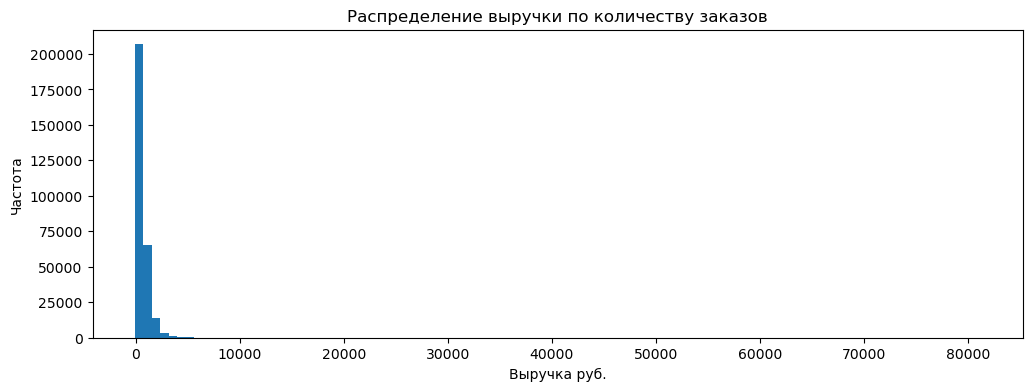

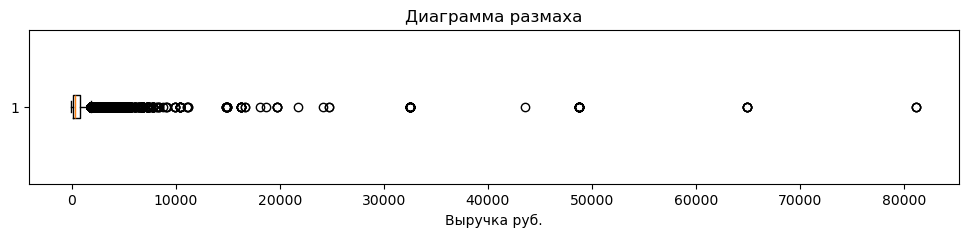

In [28]:
# построим гистограмму для revenue_rub

plt.figure(figsize=(12, 4))
plt.hist(df['revenue_rub'], bins=100)
plt.title('Распределение выручки по количеству заказов')
plt.xlabel('Выручка руб.')
plt.ylabel('Частота')
plt.show()

# боксплот для revenue_rub

plt.figure(figsize=(12, 2))
plt.boxplot(df['revenue_rub'], vert=False)
plt.title('Диаграмма размаха')
plt.xlabel('Выручка руб.')
plt.show()

In [29]:
# графики подтверждают выбросы в revenue_rub, отфильтруем значения по 99 перцентилю

p99 = df['revenue_rub'].quantile(0.99)
p99

np.float64(2628.419921875)

In [30]:
df_filtered = df[df['revenue_rub'] <= p99]

df_filtered = df_filtered[df_filtered['revenue_rub'] >= 0]

filter = len(df) - len(df_filtered)
share = filter / len(df)
print(f"Удалено: {filter} строк, это {round(share*100, 2)}% от всех данных")

Удалено: 3206 строк, это 1.1% от всех данных


In [31]:
df_filtered[['revenue_rub', 'tickets_count']].describe()

,revenue_rub,tickets_count
count,287405.000000,287405.000000
mean,518.719299,2.741323
std,511.951691,1.163087
min,0.000000,1.000000
25%,112.599998,2.000000
50%,344.829987,3.000000
75%,788.900024,3.000000
max,2628.419922,57.000000


### Промежуточный вывод

В процессе предобработки данных были сделаны следующие шаги:
- проверка на пропуски показала, что выгрузка из базы данных корректная и пропуски только там, где мы их оставили сами
- выяснили, что данные по выручке хранятся в разных валютах - конвертировали тенге в российский рубль по актуальному курсу на дату совершения покупки и сохранили его в новый столбец.
- сократили размер датафрейма, приведя данные к подходящему типу. там, где возможно привели object к категориальному типу и уменьшили разрядность числовых данных
- провели проверку в числовых столбцах, определили выбросы, подтвердили их визуально на графиках - отфильтровали по 99 процентилю и удалили отрицательные значения выручки.

## Создание профиля пользователя

In [32]:
# отсортируем по времени совершения заказа и user_id

df_sorted = df.sort_values(['user_id','order_ts']).reset_index(drop=True)

df_sorted.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,curs_for_one,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.939941,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,0.186972,1521.939941
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.450012,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск,0.183419,289.450012
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.569946,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск,0.196475,1258.569946
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.490000,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск,0.185010,8.490000
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.410034,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк,0.196648,1390.410034


In [33]:
# группируем и считаем данные

user_profiles = df_sorted.groupby('user_id').agg({
    'order_dt': ['min', 'max'],  # первый и последний заказ
    'order_id': 'count',  # количество заказов
    'revenue_rub': 'mean',  # средняя выручка
    'tickets_count': 'mean',  # среднее количество билетов
    'days_since_prev': 'mean'  # среднее время между заказами
}).reset_index()

# переименуем столбцы

user_profiles.columns = ['user_id', 'first_order_date', 'last_order_date', 
                         'total_orders', 'avg_revenue', 'avg_tickets_count', 
                         'avg_days_between_orders']

user_profiles.head()

,user_id,first_order_date,last_order_date,total_orders,avg_revenue,avg_tickets_count,avg_days_between_orders
0,0002849b70a3ce2,2024-08-20,2024-08-20,1,1521.939941,4.000000,NaN
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,2,774.010010,3.000000,75.0
2,000898990054619,2024-07-13,2024-10-23,3,767.213379,2.666667,51.0
3,00096d1f542ab2b,2024-08-15,2024-08-15,1,917.830017,4.000000,NaN
4,000a55a418c128c,2024-09-29,2024-10-15,2,61.309998,1.500000,16.0


In [34]:
# находим первые заказы

first_orders = df_sorted.groupby('user_id').first()[
    ['device_type_canonical', 'region_name', 'service_name', 'event_type_main']
].reset_index()

# переименовываем для ясности

first_orders.columns = ['user_id', 'first_device', 'first_region', 
                        'first_service', 'first_event_type']

first_orders.head()

,user_id,first_device,first_region,first_service,first_event_type
0,0002849b70a3ce2,mobile,Каменевский регион,Край билетов,театр
1,0005ca5e93f2cf4,mobile,Каменевский регион,Мой билет,выставки
2,000898990054619,mobile,Североярская область,Лови билет!,другое
3,00096d1f542ab2b,desktop,Каменевский регион,Край билетов,театр
4,000a55a418c128c,mobile,Поленовский край,Лучшие билеты,театр


In [35]:
# объединяем первые заказы с профилями

user_profiles = user_profiles.merge(first_orders, on='user_id', how='left')

user_profiles.head()

,user_id,first_order_date,last_order_date,total_orders,avg_revenue,avg_tickets_count,avg_days_between_orders,first_device,first_region,first_service,first_event_type
0,0002849b70a3ce2,2024-08-20,2024-08-20,1,1521.939941,4.000000,NaN,mobile,Каменевский регион,Край билетов,театр
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,2,774.010010,3.000000,75.0,mobile,Каменевский регион,Мой билет,выставки
2,000898990054619,2024-07-13,2024-10-23,3,767.213379,2.666667,51.0,mobile,Североярская область,Лови билет!,другое
3,00096d1f542ab2b,2024-08-15,2024-08-15,1,917.830017,4.000000,NaN,desktop,Каменевский регион,Край билетов,театр
4,000a55a418c128c,2024-09-29,2024-10-15,2,61.309998,1.500000,16.0,mobile,Поленовский край,Лучшие билеты,театр


In [36]:
# бинарные признаки

user_profiles['is_two'] = user_profiles['total_orders'] >= 2
user_profiles['is_five'] = user_profiles['total_orders'] >= 5

user_profiles.head()

,user_id,first_order_date,last_order_date,total_orders,avg_revenue,avg_tickets_count,avg_days_between_orders,first_device,first_region,first_service,first_event_type,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,1,1521.939941,4.000000,NaN,mobile,Каменевский регион,Край билетов,театр,False,False
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,2,774.010010,3.000000,75.0,mobile,Каменевский регион,Мой билет,выставки,True,False
2,000898990054619,2024-07-13,2024-10-23,3,767.213379,2.666667,51.0,mobile,Североярская область,Лови билет!,другое,True,False
3,00096d1f542ab2b,2024-08-15,2024-08-15,1,917.830017,4.000000,NaN,desktop,Каменевский регион,Край билетов,театр,False,False
4,000a55a418c128c,2024-09-29,2024-10-15,2,61.309998,1.500000,16.0,mobile,Поленовский край,Лучшие билеты,театр,True,False


### Анализ качества данных профилей

In [37]:
# общая информация

print(f"общее число пользователей в выборке: {len(user_profiles)}")
print(f"средняя выручка с одного заказа: {df_filtered['revenue_rub'].mean():.2f}")
print(f"доля пользователей, совершивших 2 и более заказа: {user_profiles['is_two'].mean():.2f}")
print(f"доля пользователей, совершивших 5 и более заказа: {user_profiles['is_five'].mean():.2f}")

общее число пользователей в выборке: 21933
средняя выручка с одного заказа: 518.72
доля пользователей, совершивших 2 и более заказа: 0.62
доля пользователей, совершивших 5 и более заказа: 0.29


### Статистические показатели

In [38]:
user_profiles['total_orders'].describe()

count    21933.000000
mean        13.249943
std        122.470535
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      10251.000000
Name: total_orders, dtype: float64

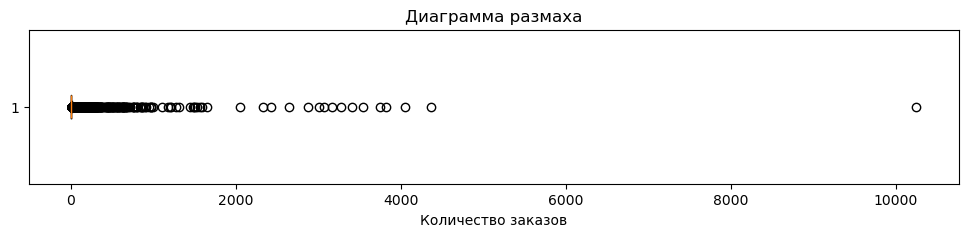

In [39]:
# обнаружен пользователь, который сделал 10251 заказ
# посмотрим боксплот

plt.figure(figsize=(12, 2))
plt.boxplot(user_profiles['total_orders'], vert=False)
plt.title('Диаграмма размаха')
plt.xlabel('Количество заказов')
plt.show()

In [40]:
# видим явные выбросы - возможно технические ошибки. посмотрим какой период анализируем

print(f"Мы располагаем данными с {df_filtered['order_dt'].min()} до {df_filtered['order_dt'].max()}")

Мы располагаем данными с 2024-06-01 00:00:00 до 2024-10-31 00:00:00


In [41]:
# получаем количество заказов за 5 месяцев - 150 дней.
# полагаю, что выбросами и ошибкой можно считать более 2000 заказов за 150 дней.
# основная масса заказов до 1800.
# до 2000 - это примерно 13 заказов в день, вполне могут делать перекупы, частные агрегаторы и т.д.

In [42]:
user_profiles['avg_tickets_count'].describe()

count    21933.000000
mean         2.755987
std          0.920739
min          1.000000
25%          2.000000
50%          2.764151
75%          3.125000
max         12.000000
Name: avg_tickets_count, dtype: float64

In [43]:
# тут аномалий не обнаружено

In [44]:
user_profiles['avg_days_between_orders'].describe()

count    13559.000000
mean        15.808537
std         22.249855
min          0.000000
25%          1.000000
50%          8.000000
75%         20.400000
max        148.000000
Name: avg_days_between_orders, dtype: float64

In [45]:
# тут аномалий не обнаружено - 148 дней между заказами, вполне укладываемся в количество дней, отведённых для анализа

In [46]:
# посмотрим значение 99.9 процентиля данных по заказам

p999 = user_profiles['total_orders'].quantile(0.999)
p999

np.float64(1479.020000000044)

In [47]:
# близко к моей логике - по нему и отфильтруем аномалии

user_profiles_filter = user_profiles[user_profiles['total_orders'] <= p999]

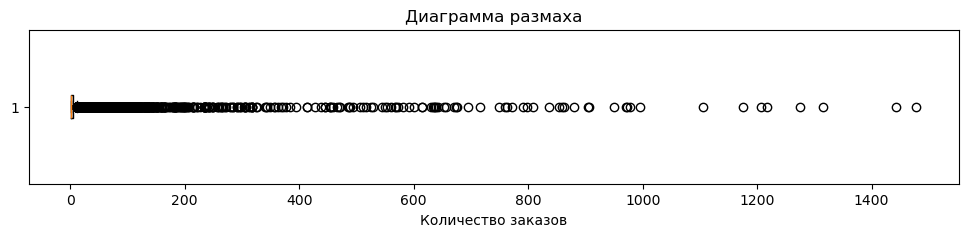

In [48]:
# посмотрим новое разпределение

plt.figure(figsize=(12, 2))
plt.boxplot(user_profiles_filter['total_orders'], vert=False)
plt.title('Диаграмма размаха')
plt.xlabel('Количество заказов')
plt.show()

In [49]:
# посчитаем потерянные данные

remove_profiles = len(user_profiles) - len(user_profiles_filter)
share_remove_profiles = remove_profiles / len(user_profiles)
print(f"Удалено: {remove_profiles} строк, это {round(share_remove_profiles*100, 2)}% от всех профилей")

Удалено: 22 строк, это 0.1% от всех профилей


### Обновлённая информация по отфильтрованным профилям пользователей

In [50]:
user_profiles_filter['total_orders'].describe()

count    21911.000000
mean        10.187851
std         48.956687
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       1478.000000
Name: total_orders, dtype: float64

In [51]:
user_profiles_filter['avg_tickets_count'].describe()

count    21911.000000
mean         2.755996
std          0.921193
min          1.000000
25%          2.000000
50%          2.764706
75%          3.125000
max         12.000000
Name: avg_tickets_count, dtype: float64

In [52]:
user_profiles_filter['avg_days_between_orders'].describe()

count    13537.000000
mean        15.834128
std         22.258240
min          0.000000
25%          1.000000
50%          8.000000
75%         20.500000
max        148.000000
Name: avg_days_between_orders, dtype: float64

In [53]:
print(f"общее число пользователей в выборке: {len(user_profiles_filter)}")
print(f"средняя выручка с одного заказа: {df_filtered['revenue_rub'].mean():.2f}")
print(f"доля пользователей, совершивших 2 и более заказа: {user_profiles_filter['is_two'].mean():.2f}")
print(f"доля пользователей, совершивших 5 и более заказа: {user_profiles_filter['is_five'].mean():.2f}")

общее число пользователей в выборке: 21911
средняя выручка с одного заказа: 518.72
доля пользователей, совершивших 2 и более заказа: 0.62
доля пользователей, совершивших 5 и более заказа: 0.29


## Исследовательский анализ данных

### Исследование признаков первого заказа

In [54]:
# распределение пользователей по типу их первого мероприятия

first_event_stats = user_profiles_filter['first_event_type'].value_counts() # абсолютные значения
first_event_share = user_profiles_filter['first_event_type'].value_counts(normalize=True) # доли

display(first_event_stats)

first_event_share

first_event_type
концерты    9688
другое      5485
театр       4308
стендап     1118
спорт        803
выставки     414
ёлки          95
Name: count, dtype: int64

first_event_type
концерты    0.442152
другое      0.250331
театр       0.196614
стендап     0.051025
спорт       0.036648
выставки    0.018895
ёлки        0.004336
Name: proportion, dtype: float64

In [55]:
# распределение пользователей по типу устройства, с которого совершена первая покупка

first_device_stats = user_profiles_filter['first_device'].value_counts() # абсолютные значения
first_device_share = user_profiles_filter['first_device'].value_counts(normalize=True) # доли

display(first_device_stats)

first_device_share

first_device
mobile     18141
desktop     3770
Name: count, dtype: int64

first_device
mobile     0.82794
desktop    0.17206
Name: proportion, dtype: float64

In [56]:
# распределение пользователей по региону проведения мероприятия из первого заказа

first_region_stats = user_profiles_filter['first_region'].value_counts() # абсолютные значения
first_region_share = user_profiles_filter['first_region'].value_counts(normalize=True) # доли

display(first_region_stats.head())

first_region_share.head()

first_region
Каменевский регион      7203
Североярская область    3790
Широковская область     1242
Озернинский край         679
Малиновоярский округ     536
Name: count, dtype: int64

first_region
Каменевский регион      0.328739
Североярская область    0.172972
Широковская область     0.056684
Озернинский край        0.030989
Малиновоярский округ    0.024463
Name: proportion, dtype: float64

In [57]:
# распределение пользователей по сервису, продавшему билеты на первый заказ

first_service_stats = user_profiles_filter['first_service'].value_counts() # абсолютные значения
first_service_share = user_profiles_filter['first_service'].value_counts(normalize=True) # доли

display(first_service_stats.head())

first_service_share.head()

first_service
Билеты без проблем    5230
Мой билет             3020
Лови билет!           2849
Билеты в руки         2583
Облачко               2192
Name: count, dtype: int64

first_service
Билеты без проблем    0.238693
Мой билет             0.137830
Лови билет!           0.130026
Билеты в руки         0.117886
Облачко               0.100041
Name: proportion, dtype: float64

Распределение неравномерное. По всем четырём признакам есть выраженные «точки входа»:

- концерты — лидер по типу первого события: 44 %
- мобильные устройства — 83 % первых покупок делаются именно с мобильных
- каменевский регион — главный источник первых покупок: 33 %
- сервис `Билеты без проблем` — лидирует по первым покупкам: 24 %

Топ-5 сервисов:

1. Билеты без проблем
2. Мой билет
3. Лови билет!
4. Билеты в руки
5. Облачко

Почти `70 % всех первых покупок` проходят через эти 5 площадок


### Исследование вернувшихся пользователей + графики

In [58]:
# отфильтруем пользователей по заказам - нужны только 2 и более заказа

user_profiles_filter_orders = user_profiles_filter[user_profiles_filter['total_orders'] > 1]

upfo = user_profiles_filter_orders

len(upfo)

13537

In [59]:
# сгруппируем по сегментам и посчитаем

upfo_first_event = upfo.groupby('first_event_type', observed=True).size().sort_values(ascending=False)
upfo_first_device = upfo.groupby('first_device', observed=True).size().sort_values(ascending=False)
upfo_first_region = upfo.groupby('first_region', observed=True).size().sort_values(ascending=False)
upfo_first_service = upfo.groupby('first_service', observed=True).size().sort_values(ascending=False)

# добавляем долю

upfo_first_event_share = (upfo_first_event / first_event_stats).round(4).sort_values(ascending=False)
upfo_first_device_share = (upfo_first_device / first_device_stats).round(4).sort_values(ascending=False)
upfo_first_region_share = (upfo_first_region / first_region_stats).round(4).sort_values(ascending=False)
upfo_first_service_share = (upfo_first_service / first_service_stats).round(4).sort_values(ascending=False)

In [60]:
# собираем таблицу по мероприятиям

event_df = pd.DataFrame({
    'total': first_event_stats,
    '>2_orders': upfo_first_event,
    'Share': upfo_first_event_share
}).sort_values('Share', ascending=False)

print("\nРаспределение пользователей по мероприятиям с долями")
display(event_df)


Распределение пользователей по мероприятиям с долями


,total,>2_orders,Share
first_event_type,,,
выставки,414,265,0.6401
театр,4308,2751,0.6386
концерты,9688,6040,0.6235
стендап,1118,682,0.6100
другое,5485,3296,0.6009
спорт,803,451,0.5616
ёлки,95,52,0.5474


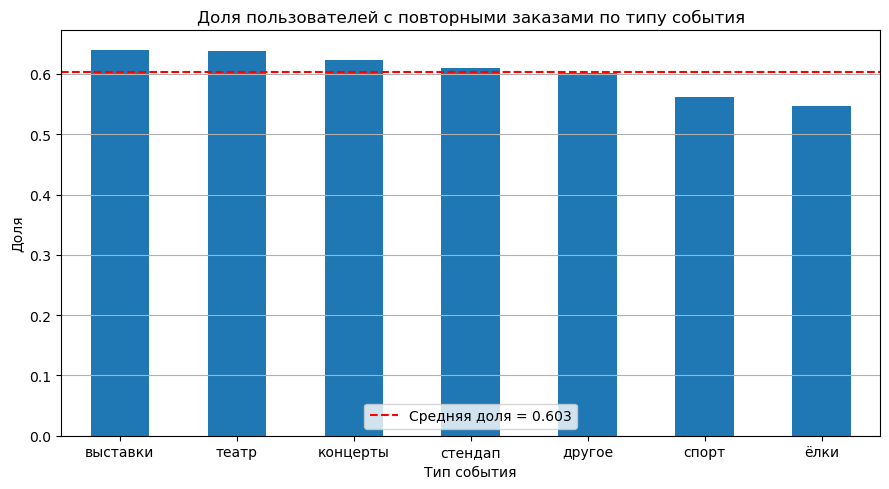

In [61]:
# средняя доля по всем мероприятиям

avg_event_share = event_df['Share'].mean()

plt.figure(figsize=(9, 5))
upfo_first_event_share.plot(kind='bar')

# добавляем среднюю

plt.axhline(avg_event_share, color='red', linestyle='--', label=f"Средняя доля = {avg_event_share:.3f}")

plt.title('Доля пользователей c повторными заказами по типу события')
plt.xlabel('Тип события')
plt.ylabel('Доля')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(loc='lower center')
plt.tight_layout()
plt.show()

In [62]:
# собираем таблицу по устройствам

device_df = pd.DataFrame({
    'total': first_device_stats,
    '>2_orders': upfo_first_device,
    'Share': upfo_first_device_share
}).sort_values('Share', ascending=False)

print("\nРаспределение пользователей по устройству с долями")
display(device_df)


Распределение пользователей по устройству с долями


,total,>2_orders,Share
first_device,,,
desktop,3770,2421,0.6422
mobile,18141,11116,0.6128


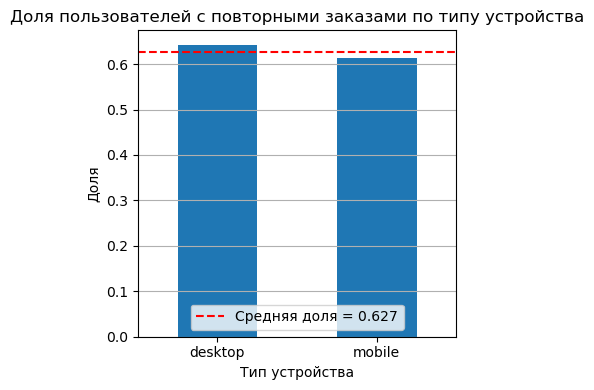

In [63]:
# средняя доля по всем устройствам

avg_device_share = device_df['Share'].mean()

plt.figure(figsize=(4, 4))
upfo_first_device_share.plot(kind='bar')

# добавляем среднюю

plt.axhline(avg_device_share, color='red', linestyle='--', label=f"Средняя доля = {avg_device_share:.3f}")

plt.title("Доля пользователей c повторными заказами по типу устройства")
plt.xlabel('Тип устройства')
plt.ylabel('Доля')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(loc='lower center')
plt.tight_layout()
plt.show()

In [76]:
# собираем таблицу по регионам

region_df = pd.DataFrame({
    'total': first_region_stats,
    '>2_orders': upfo_first_region,
    'Share': upfo_first_region_share
})

# берём топ 10 по количеству пользователей

region_top10 = region_df.sort_values('total', ascending=False).head(10)

print("\nРаспределение пользователей по региону с долями")
display(region_top10)


Распределение пользователей по региону с долями


,total,>2_orders,Share
first_region,,,
Каменевский регион,7203,4525.0,0.6282
Североярская область,3790,2433.0,0.6420
Широковская область,1242,808.0,0.6506
Озернинский край,679,375.0,0.5523
Малиновоярский округ,536,303.0,0.5653
Шанырский регион,509,349.0,0.6857
Травяная область,494,306.0,0.6194
Светополянский округ,468,310.0,0.6624
Речиновская область,441,282.0,0.6395


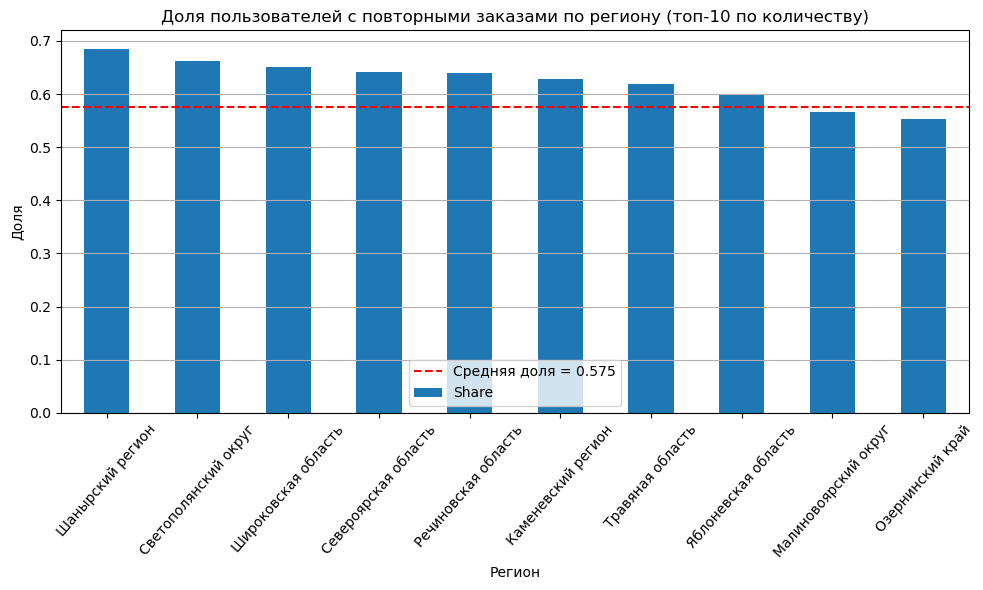

In [65]:
# сортируем топ 10 регионов по доли

region_top10_sorted_by_share = region_top10.sort_values('Share', ascending=False)

# средняя доля по всем регионам

avg_region_share = region_df['Share'].mean()

plt.figure(figsize=(10, 6))
region_top10_sorted_by_share['Share'].plot(kind='bar')

# добавляем среднюю

plt.axhline(avg_region_share, color='red', linestyle='--', label=f"Средняя доля = {avg_region_share:.3f}")

plt.title("Доля пользователей c повторными заказами по региону (топ-10 по количеству)")
plt.xlabel('Регион')
plt.ylabel('Доля')
plt.xticks(rotation=49)
plt.grid(axis='y')
plt.legend(loc='lower center')
plt.tight_layout()
plt.show()

In [66]:
# собираем таблицу по сервисам

service_df = pd.DataFrame({
    'total': first_service_stats,
    '>2_orders': upfo_first_service,
    'Share': upfo_first_service_share
})

# берём топ 10 по количеству пользователей

service_top10 = service_df.sort_values('total', ascending=False).head(10)

print("\nРаспределение пользователей по сервису с долями")
display(service_top10)


Распределение пользователей по сервису с долями


,total,>2_orders,Share
first_service,,,
Билеты без проблем,5230,3179.0,0.6078
Мой билет,3020,1853.0,0.6136
Лови билет!,2849,1754.0,0.6157
Билеты в руки,2583,1631.0,0.6314
Облачко,2192,1351.0,0.6163
Весь в билетах,1319,839.0,0.6361
Лучшие билеты,1186,728.0,0.6138
Прачечная,592,373.0,0.6301
Край билетов,462,303.0,0.6558


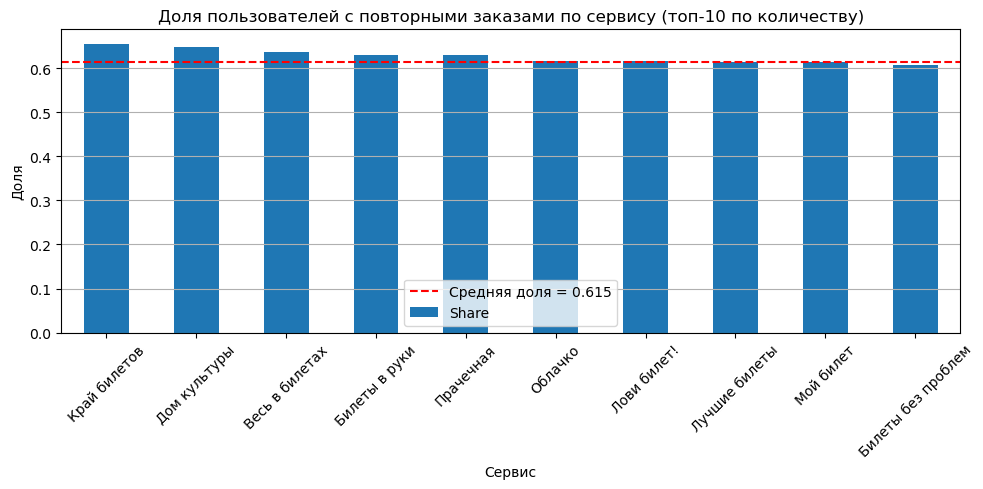

In [67]:
# сортируем топ 10 сервисов по доли

service_top10_sorted_by_share = service_top10.sort_values('Share', ascending=False)

# средняя доля по всем сервисам

avg_service_share = service_df['Share'].mean()

plt.figure(figsize=(10, 5))
service_top10_sorted_by_share['Share'].plot(kind='bar')

# добавляем среднюю

plt.axhline(avg_service_share, color='red', linestyle='--', label=f"Средняя доля = {avg_service_share:.3f}")

plt.title("Доля пользователей c повторными заказами по сервису (топ-10 по количеству)")
plt.xlabel('Сервис')
plt.ylabel('Доля')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(loc='lower center')
plt.tight_layout()
plt.show()

Чаще всего возвращаются пользователи, которые:
- впервые купили выставки, театр, концерты, стендап (в этих же сегментах доля вернувшихся выше, чем в среднем по выборке)
- использовали desktop (в этом же сегменте доля вернувшихся выше, чем в среднем по выборке, хотя показатели возвратов примерно равны, но в сегменте mobile доля вернувшихся немного ниже чем в среднем по всем устройствам)
- живут в Североярской области, Каменевском регионе, Широковской области и практически весь топ 10 регионов по количеству пользователей имеет показатель возвратов выше, чем по всем регионам в среднем (исключения - Малиновоярский округ и Озернинский край)
- впервые покупали через Край билетов, Дом культуры, Весь в билетах, Прачечную. В этих сегментах также доля вернувшихся выше чем в среднем по всем сервисам. И они также в топ 10 по количеству пользователей.

### Проверка продуктовых гипотез

Гипотеза 1. Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.

In [71]:
display(event_df.loc[['спорт', 'концерты']])

,total,>2_orders,Share
first_event_type,,,
спорт,803,451,0.5616
концерты,9688,6040,0.6235


Как можно видеть из таблицы - гипотеза не подтверждается, а даже наоборот - опровергается. Пользователи, впервые купившие билеты на спортивные мероприятия, реже возвращаются, чем те, кто пришёл через концерты.

Гипотеза 2. В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.


In [74]:
# постоим корелляционную матрицу по методу Пирсона

display(region_df.corr(method='pearson'))

,total,>2_orders,Share
total,1.000000,0.999786,0.115867
>2_orders,0.999786,1.000000,0.121311
Share,0.115867,0.121311,1.000000


Корреляция между размером региона и долей повторных = 0.116. Это означает:

- связь очень слабая, почти нулевая.
- размер региона практически не влияет на то, насколько лояльны пользователи из него.
- крупные регионы дают много повторных пользователей только потому, что там много пользователей вообще, а не потому, что там выше удержание.

### Исследование поведения пользователей через показатели выручки и состава заказа¶